StaticArrays version: https://github.com/genkuroki/public/blob/main/0018/HMC%20leapfrog%20StaticArrays.ipynb

In [1]:
module My

using ConcreteStructs: @concrete
using ForwardDiff: derivative
using Parameters: @unpack
using Random: default_rng

@concrete struct LFProblem ϕ; H; F; dt; nsteps end

"""ϕ should be a potential function."""
function LFProblem(ϕ; dt = 0.05, nsteps = 100)
    H(x, v, param) = v^2/2 + ϕ(x, param)
    F(x, param) = -derivative(x -> ϕ(x, param), x)
    LFProblem(ϕ, H, F, dt, nsteps)
end

function update(lf::LFProblem, x, v, param)
    @unpack dt, F = lf
    vtmp = v + F(x, param)*dt/2
    xnew = x + vtmp*dt
    vnew = vtmp + F(xnew, param)*dt/2
    xnew, vnew
end

"""Numerically solve Hamilton's equation of motion with leapfrog method"""
function solve(lf::LFProblem, x, v, param)
    @unpack nsteps = lf
    for _ in 1:nsteps
        x, v = update(lf, x, v, param)
    end
    x, v
end

function _update!(lf::LFProblem{dim}, x, T, param, rng) where dim
    @unpack H = lf
    v = randn(rng, T)
    xnew, vnew = solve(lf, x, v, param)
    dH = H(xnew, vnew, param) - H(x, v, param)
    alpha = min(1, exp(-dH))
    rand(rng) ≤ alpha ? xnew : x
end

"""Hamiltonian Monte Carlo"""
function HMC(lf::LFProblem, param = nothing;
        niters = 10^5, burnin = 0, rng = default_rng(),
        x0 = randn())
    T = typeof(x0)
    x = x0
    for _ in 1:burnin
        x = _update!(lf, x, T, param, rng)
    end
    X = Vector{T}(undef, niters)
    for i in 1:niters
        x = _update!(lf, x, T, param, rng)
        X[i] = x
    end
    X
end

end

Main.My

In [2]:
using Plots
using QuadGK
using BenchmarkTools

  0.326136 seconds (2.18 M allocations: 66.156 MiB, 3.45% gc time, 60.86% compilation time)


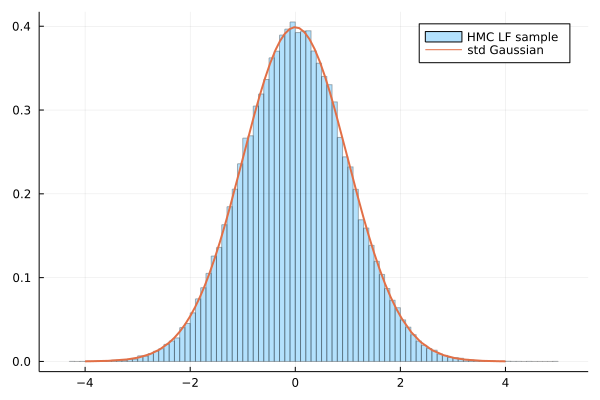

In [3]:
ϕ(x, param=nothing) = x^2/2
lf = My.LFProblem(ϕ)
@time X = My.HMC(lf)
histogram(X; norm=true, alpha=0.3, label="HMC LF sample")
plot!(x -> exp(-x^2/2)/√(2π), -4, 4, label="std Gaussian", lw=2)

In [4]:
@btime My.HMC($lf);

  119.528 ms (1600013 allocations: 29.75 MiB)


  0.307902 seconds (2.10 M allocations: 60.888 MiB, 2.68% gc time, 48.05% compilation time)


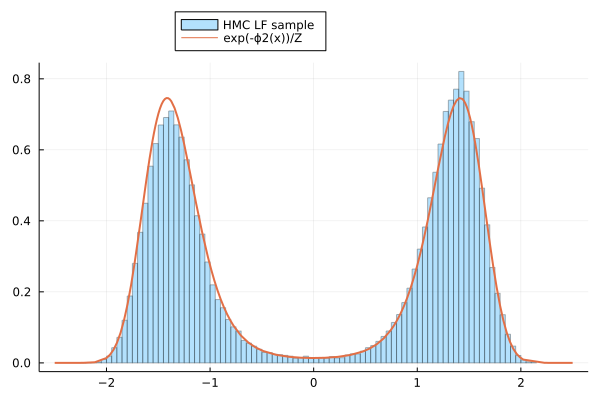

In [5]:
ϕ2(x, param=nothing) = x^4 - 4x^2
Z = quadgk(x -> exp(-ϕ2(x)), -Inf, Inf)[1]
lf2 = My.LFProblem(ϕ2)
@time X2 = My.HMC(lf2)
histogram(X2; norm=true, alpha=0.3, label="HMC LF sample", bin=100)
plot!(x -> exp(-ϕ2(x))/Z, -2.5, 2.5; label="exp(-ϕ2(x))/Z", lw=2)
plot!(; legend=:outertop)

In [6]:
@btime My.HMC($lf2);

  149.630 ms (1600161 allocations: 29.76 MiB)


https://github.com/genkuroki/public/blob/main/0019/HMC%20leapfrog.ipynb

  1.768335 seconds (16.36 M allocations: 319.595 MiB, 1.66% gc time, 6.73% compilation time)


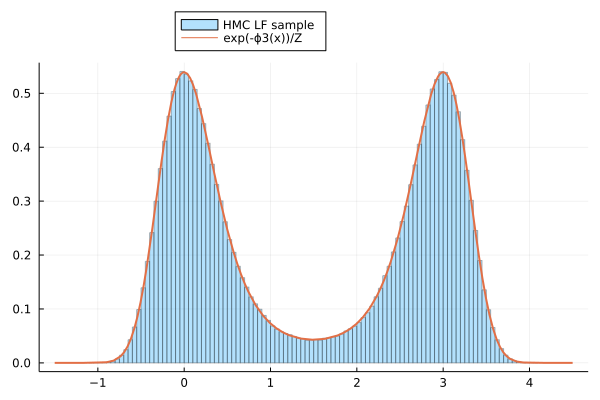

In [7]:
ϕ3(x, param=nothing) = x^2*(x - 3)^2/2
Z = quadgk(x -> exp(-ϕ3(x)), -Inf, Inf)[1]
lf3 = My.LFProblem(ϕ3)
@time X3 = My.HMC(lf3; niters=10^6)
histogram(X3; norm=true, alpha=0.3, label="HMC LF sample", bin=100)
plot!(x -> exp(-ϕ3(x))/Z, -1.5, 4.5; label="exp(-ϕ3(x))/Z", lw=2)
plot!(; legend=:outertop)

In [8]:
@btime My.HMC($lf3; niters=10^6);

  1.653 s (16001150 allocations: 297.56 MiB)


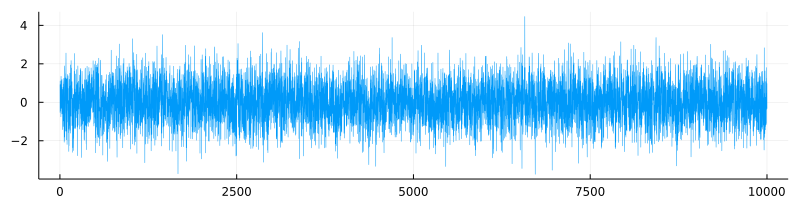

In [9]:
plot(X[1:10000]; label="", size=(800, 200), lw=0.5)

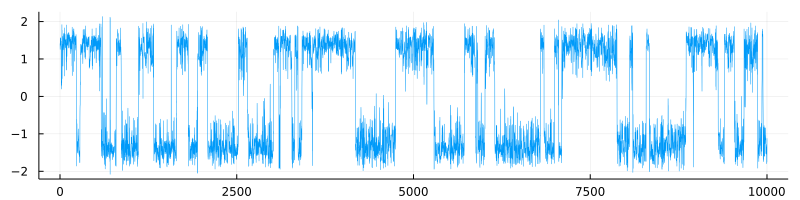

In [10]:
plot(X2[1:10000]; label="", size=(800, 200), lw=0.5)

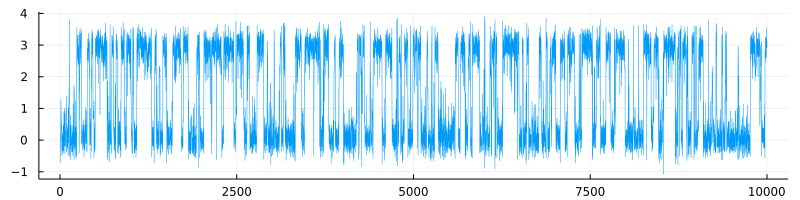

In [11]:
plot(X3[1:10000]; label="", size=(800, 200), lw=0.5)

  0.242062 seconds (1.86 M allocations: 45.750 MiB, 4.13% gc time, 37.30% compilation time)
  0.167597 seconds (1.60 M allocations: 29.761 MiB, 5.70% gc time)
  0.162099 seconds (1.60 M allocations: 29.764 MiB)
  0.164813 seconds (1.60 M allocations: 29.764 MiB, 3.69% gc time)
  0.158960 seconds (1.60 M allocations: 29.767 MiB)
  0.167014 seconds (1.60 M allocations: 29.770 MiB, 3.08% gc time)


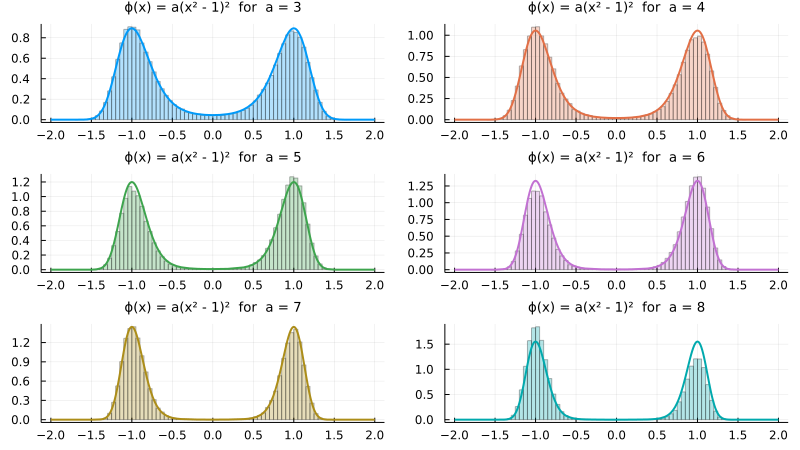

In [12]:
ϕ4(x, a) = a * (x^2 - 1)^2
a = [3, 4, 5, 6, 7, 8]
XX = Vector{Float64}[]
ZZ = Float64[]
PP = []
for i in eachindex(a)
    Z = quadgk(x -> exp(-ϕ4(x, a[i])), -Inf, Inf)[1]
    push!(ZZ, Z)
    lf = My.LFProblem(ϕ4)
    @time X = My.HMC(lf, a[i])
    flush(stdout)
    push!(XX, X)
    P = plot()
    histogram!(X; norm=true, alpha=0.3, label="HMC LF sample", bin=100, c=i)
    plot!(x -> exp(-ϕ4(x, a[i]))/Z, -2, 2; label="exp(-ϕ2(x))/Z", lw=2, c=i)
    plot!(; legend=false, xtick=-2:0.5:2)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(PP, P)
end
plot(PP...; size=(800, 450), layout=(3, 2))

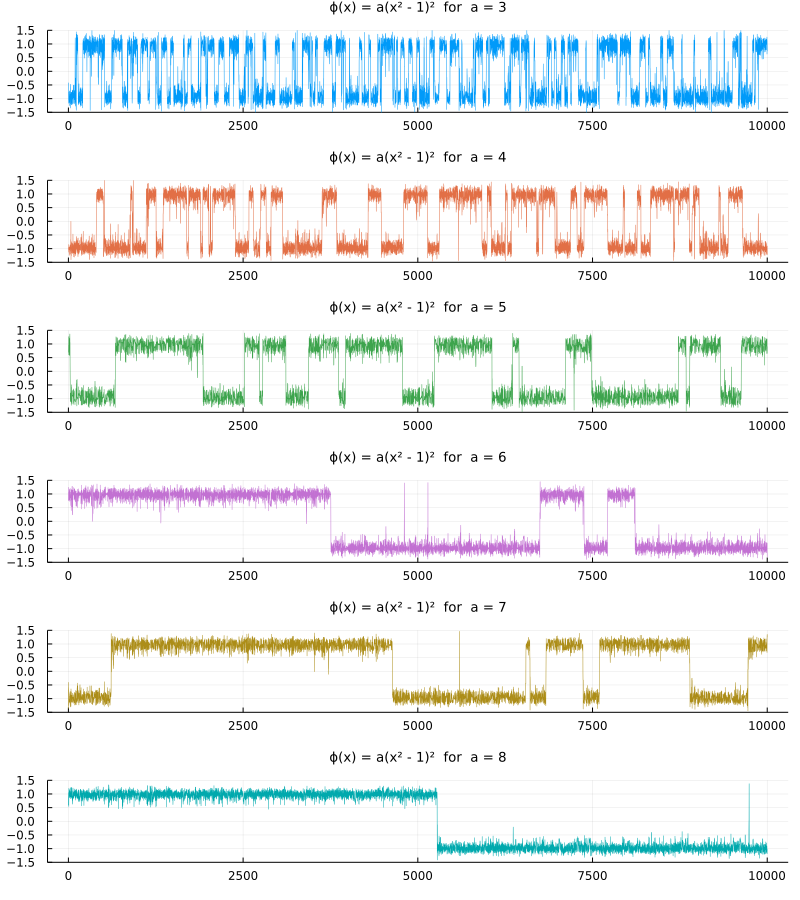

In [13]:
QQ = []
for i in eachindex(a)
    Q = plot(XX[i][1:10000]; ylim=(-1.5, 1.5), label="", c=i, lw=0.5)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(QQ, Q)
end
plot(QQ...; size=(800, 900), layout=(length(a), 1))

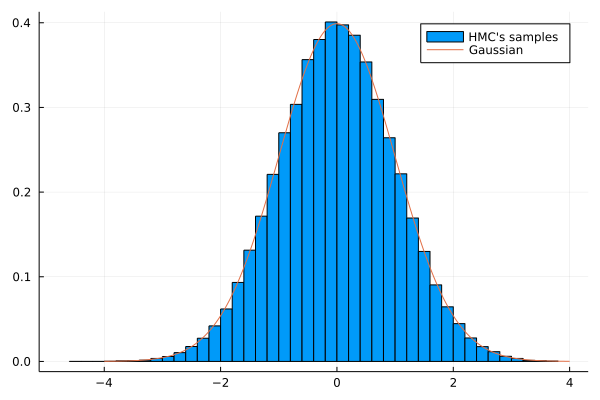

  1.549538 seconds (55.40 M allocations: 1.048 GiB, 5.48% gc time, 9.78% compilation time)


In [14]:
# https://github.com/moruten/julia-code/blob/c0dfc2443d6b74256364e698b3edb37f98214ce7/Test-2021-9-3-no4.ipynb

#HMC method
using Plots
using StatsBase
using Random
using Printf
using Distributions
using BenchmarkTools
using QuadGK
using SpecialFunctions
using Zygote

# Generating Gaussian distribution (1-dim) by using HMC method

# # of configurations
n_config = 1_00_000

# size of a configuration
n_size = 1

# # of step of Leapfrog method
n_tau = 100

# time period of Hamilton equation
τ = 5.0

function S(x)
    sum(0.5*x[i]^2 for i=1:n_size)
end

function dSdx(x,k)
    return x
end

function H(x,p)
    K = sum(p[i]^2 for i=1:n_size)
    return S(x) + 0.5*K
end

#１変数更新のHMC法
function HMC_1dim(x)
        #初期化
        p_ini = rand(Normal(0,1),n_size)
        p_fin = zeros(n_size)
        x_ini = zeros(n_size)
        x_fin = zeros(n_size)
    
        #初期配位を保存
        for i=1:n_size x_ini[i] = x[i] end
    
        #初期配位のハミルトニアンを計算
        H_ini = H(x_ini,p_ini)
    
        #リープフロッグで時間発展
        leapfrog!(x,p_ini)
    
        #時間発展後の配位を保存
        for i=1:n_size x_fin[i] = x[i]; p_fin[i] = p_ini[i] end
    
        #時間発展後のハミルトニアンを計算
        H_fin = H(x_fin,p_fin)
    
        #Metropolis check
        r=rand()
        if r<exp(H_ini - H_fin)
            for i=1:n_size x[i] = x_fin[i] end
        else
            for i=1:n_size x[i] = x_ini[i] end
        end
end

#x,pをリープフロッグ法で更新する．
function leapfrog!(x,p)
    Δτ  = τ/n_tau 
    p0  = 0.0
    p1  = 0.0
    x05 = 0.0
    x15 = 0.0
    for k=1:n_size
        #initial setting : τ0
        p0  = p[k]
        x05 = x[k] + p0 * 0.5*Δτ
    
        #(n-1)step : τ0 -> τn-1 
        for i=1:n_tau-1
            p1  = p0 - dSdx(x05,k)*Δτ
            x15 = x05 + p1*Δτ
        
            p0  = p1
            x05 = x15
        end
    
        #final step : τn-1 -> τn
        p_end = p1 - dSdx(x15,k)*Δτ
        x_end = x15 + p_end*0.5*Δτ
        
        x[k]  = x_end
        p[k]  = p_end
    end
end

""" main """
#set of configurations
Ω = zeros(n_config)

#configuration
x = zeros(n_size)

@time for j=1:n_config
    HMC_1dim(x)
    Ω[j] = x[1]
end

Ω

gauss(x) = exp(-0.5*x^2)/sqrt(2*pi)
xr = range(-4,4,length=10001)

plot(Ω,st=:histogram,nbins=50,norm=:pdf,label="HMC's samples")
plot!(xr,gauss.(xr),label="Gaussian") |> display

In [15]:
function HMC_orig!()
    for j=1:n_config
        HMC_1dim(x)
        Ω[j] = x[1]
    end
end

""" main """
#set of configurations
Ω = zeros(n_config)

#configuration
x = zeros(n_size)

@btime HMC_orig!()

  1.350 s (54998979 allocations: 1.02 GiB)


In [16]:
length(Ω), length(X)

(100000, 100000)

In [17]:
1.3/0.080

16.25